In [2]:
import os
import sys
import torch
import wandb
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import  Dict
from pathlib import Path
from tqdm import tqdm, trange
from functools import partial
from vit_sae_analysis.dashboard_fns import get_feature_data, FeatureData
from IPython.display import Image, display



sys.path.append("..")

from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer import data_fns, html_fns
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData
from sae_training.config import ViTSAERunnerConfig
from sae_training.vit_runner import vision_transformer_sae_runner
from sae_training.train_sae_on_vision_transformer import train_sae_on_vision_transformer
from vit_sae_analysis.dashboard_fns import get_feature_data, FeatureData
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import ViTSparseAutoencoderSessionloader
from vit_sae_analysis.dashboard_fns import get_all_model_activations, get_sae_activations
from torchvision import transforms, datasets
from torchvision.utils import save_image


# Paramters
number_of_images = 10


import os
import shutil


if torch.backends.mps.is_available():
    device = "mps" 
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
sae_path = "checkpoints/r9ompyb5/final_sparse_autoencoder_vit_base_patch32_clip_224_10_resid_49152.pt"

loaded_object = torch.load(sae_path)

cfg = loaded_object['cfg']

state_dict = loaded_object['state_dict']

sparse_autoencoder = SparseAutoencoder(cfg)

sparse_autoencoder.load_state_dict(state_dict)

sparse_autoencoder.eval()

loader = ViTSparseAutoencoderSessionloader(cfg)

model = loader.get_model(cfg.model_name)
model.to(cfg.device)

torch.cuda.empty_cache()
sparse_autoencoder.eval()


/opt/conda/envs/mats_sae_training/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/envs/mats_sae_training/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/envs/mats_sae_training/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [8]:

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((sparse_autoencoder.cfg.image_width, sparse_autoencoder.cfg.image_height)),  # Resize the image to WxH pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])
dataset = load_dataset(sparse_autoencoder.cfg.dataset_path, split="train")

if sparse_autoencoder.cfg.dataset_path=="cifar100":
    image_key = 'img'
else:
    image_key = 'image'


# Select a smaller dataset to process the images. By default, the datset contains at most 250_000 images
max_dataset_size = 250_000 # Put this in the cfg file
if len(dataset)>max_dataset_size:
    dataset = dataset.shuffle().select(range(max_dataset_size))
    
iterable_dataset = iter(dataset)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

In [9]:
images = []
for image in trange(number_of_images, desc = "Getting images for dashboard"):
    with torch.no_grad():
        try:
            images.append(transform(next(iterable_dataset)[image_key]))
        except StopIteration:
            iterable_dataset = iter(dataset.shuffle())
            images.append(transform(next(iterable_dataset)[image_key]))
images = torch.stack(images, dim=0)
images = images.to(sparse_autoencoder.cfg.device)

model_activations = get_all_model_activations(images, model, sparse_autoencoder.cfg) # tensor of size [batch, d_resid]
sae_activations = get_sae_activations(model_activations, sparse_autoencoder, torch.tensor(range(cfg.d_sae))) # tensor of size [batch, feature_idx]
del model_activations

Getting images for dashboard: 100%|██████████| 10/10 [00:00<00:00, 432.95it/s]
Dashboard: forward pass images through ViT: 0it [00:00, ?it/s]
Dashboard: obtaining sae activations: 0it [00:00, ?it/s]


In [10]:
def show_maes(feature):
    print(f"Feature {feature}")
    feature_path = f"./dashboard/{feature}/max_activating"
    maes_file_names = os.listdir(feature_path)
    activations = [float(i.split(".png")[0]) for i in maes_file_names]
    paths = [f"{feature_path}/{i}" for i in maes_file_names]

    # def get_feature_maes(feature):
    for image_path in paths:
        display(Image(filename=image_path))
    print("-----")



12.991738319396973
Feature 17397


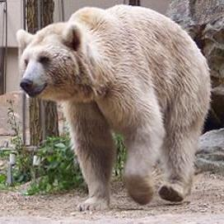

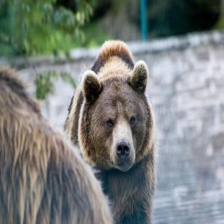

-----
5.832901477813721
Feature 38182


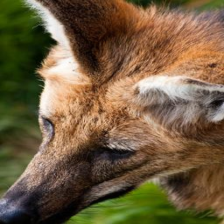

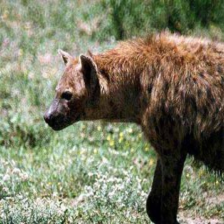

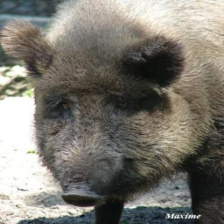

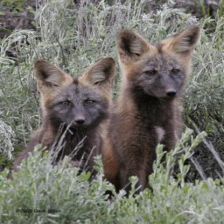

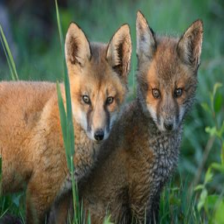

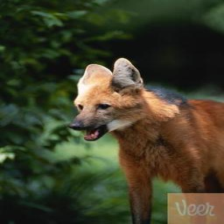

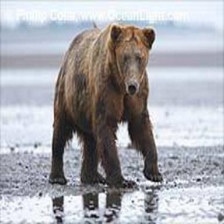

-----
3.59830379486084
Feature 10447


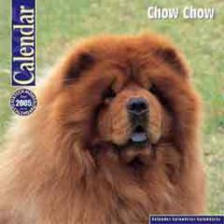

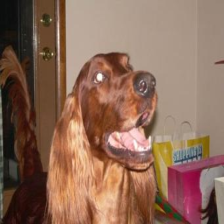

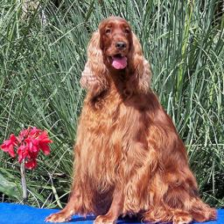

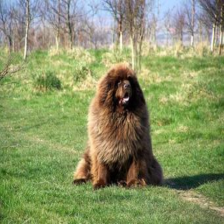

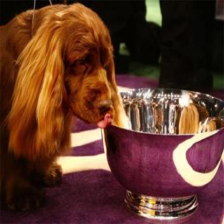

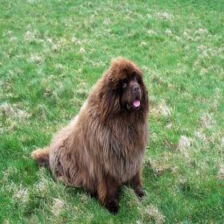

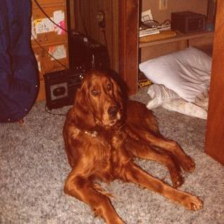

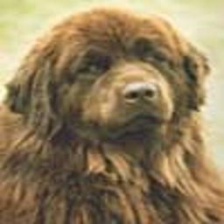

-----
2.797783136367798
Feature 14676


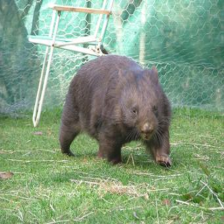

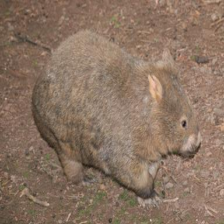

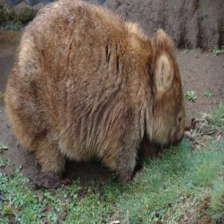

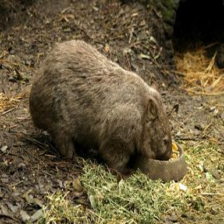

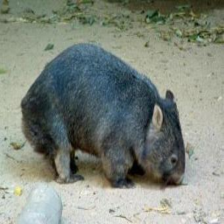

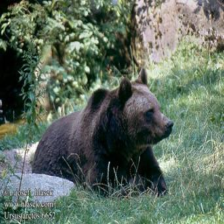

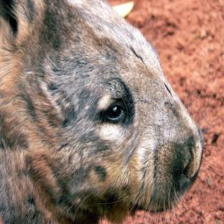

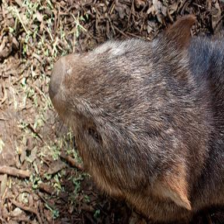

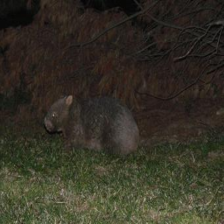

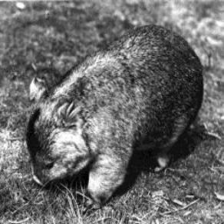

-----
1.9193274974822998
Feature 11039


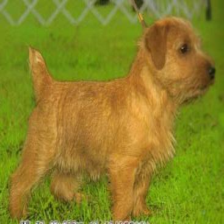

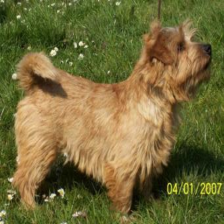

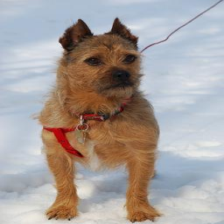

-----


In [11]:
image_index = 9
px.imshow(images[image_index].permute(1,2,0).detach().cpu().numpy()).show()

px.line(
    sae_activations[image_index].detach().cpu(),
).show()

vals, inds = torch.topk(sae_activations[image_index].detach().cpu(), 5)
for val, ind in zip(vals,inds):
    print(val.item())
    show_maes(ind)